In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import os

In [1]:
!pip install kaggle mplcyberpunk torchutils -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 9.9 MB/s eta 0:00:00


In [3]:
!kaggle datasets download -d gpiosenka/sports-classification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
 96% 406M/424M [00:03<00:00, 124MB/s]
100% 424M/424M [00:03<00:00, 112MB/s]


In [4]:
!unzip -qq /content//sports-classification.zip

In [5]:
trnsfrms_train = T.Compose([
    T.RandomRotation(45),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.Resize((224, 224)),
    T.ToTensor(),
    ]
)

trnsfrms_valid = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    ]
)

In [6]:
train_dataset = torchvision.datasets.ImageFolder('/content/train',
                                                 transform=trnsfrms_train)
valid_dataset = torchvision.datasets.ImageFolder('/content/test',
                                                 transform=trnsfrms_valid)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [8]:
from torchvision.models import resnet50, ResNet50_Weights

In [9]:
class MyResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(2048, 100)
        for i in self.model.parameters():
            i.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [10]:
model = MyResNet50()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
device = 'cuda'

[Epoch 00] Train loss: 2.1209, valid loss = 1.3831 Train acc 0.5611 Valid acc 0.8747
[Epoch 01] Train loss: 0.9387, valid loss = 0.7370 Train acc 0.7896 Valid acc 0.8845
[Epoch 02] Train loss: 0.6907, valid loss = 0.3746 Train acc 0.8374 Valid acc 0.9084
[Epoch 03] Train loss: 0.5672, valid loss = 0.7712 Train acc 0.8650 Valid acc 0.9303
[Epoch 04] Train loss: 0.4860, valid loss = 0.8707 Train acc 0.8823 Valid acc 0.9244
[Epoch 05] Train loss: 0.4239, valid loss = 0.3860 Train acc 0.8980 Valid acc 0.9414
[Epoch 06] Train loss: 0.3806, valid loss = 0.3701 Train acc 0.9087 Valid acc 0.9318
[Epoch 07] Train loss: 0.3419, valid loss = 0.2750 Train acc 0.9158 Valid acc 0.9449
[Epoch 08] Train loss: 0.3113, valid loss = 0.3324 Train acc 0.9211 Valid acc 0.9292
[Epoch 09] Train loss: 0.3008, valid loss = 0.3948 Train acc 0.9230 Valid acc 0.9313
[Epoch 10] Train loss: 0.2629, valid loss = 0.2584 Train acc 0.9354 Valid acc 0.9283
[Epoch 11] Train loss: 0.2516, valid loss = 0.1824 Train acc 0.93

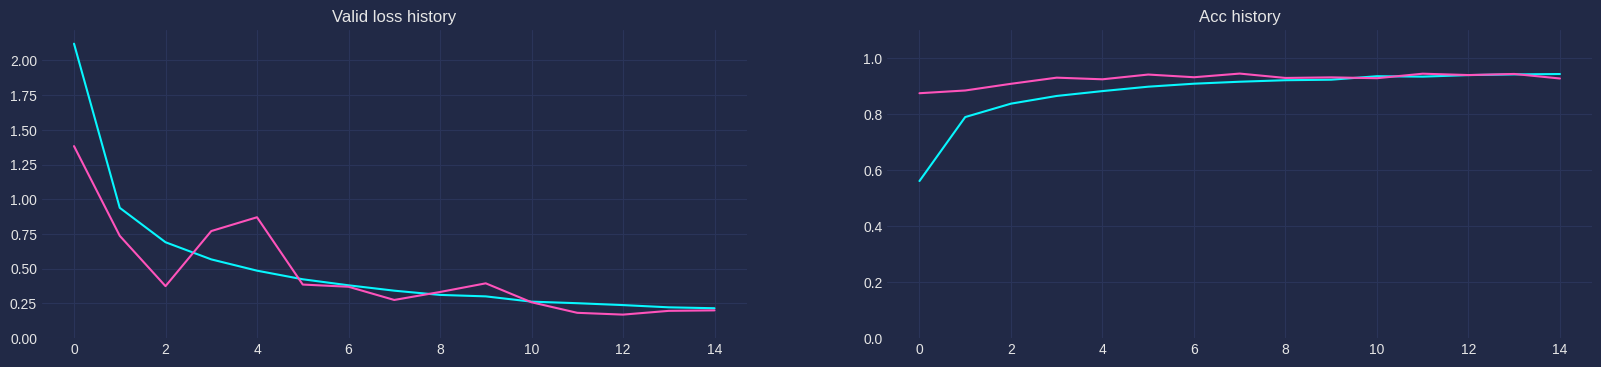

In [13]:
model.to(device)

train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(15):

    loss_batch = []
    acc_batch  = []

    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        #print(labels.size(), labels)
        preds = model(images)
        #preds = torch.squeeze(preds, -1)
        #print(preds.size(), preds)
        loss = criterion(preds, labels)

        loss_batch.append(loss.item())
        acc_batch.append((preds.argmax(axis=1) == labels).cpu().numpy().mean())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)

        loss_batch.append(loss.item())
        acc_batch.append((preds.argmax(axis=1) == labels).cpu().numpy().mean())


    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))
    print(f'[Epoch {epoch:02d}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_epoch_losses)
ax[0].plot(valid_epoch_losses)
ax[0].set_ylim((0, np.max(train_epoch_losses.extend(valid_epoch_losses))))
ax[0].set_title('Valid loss history')

ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history');

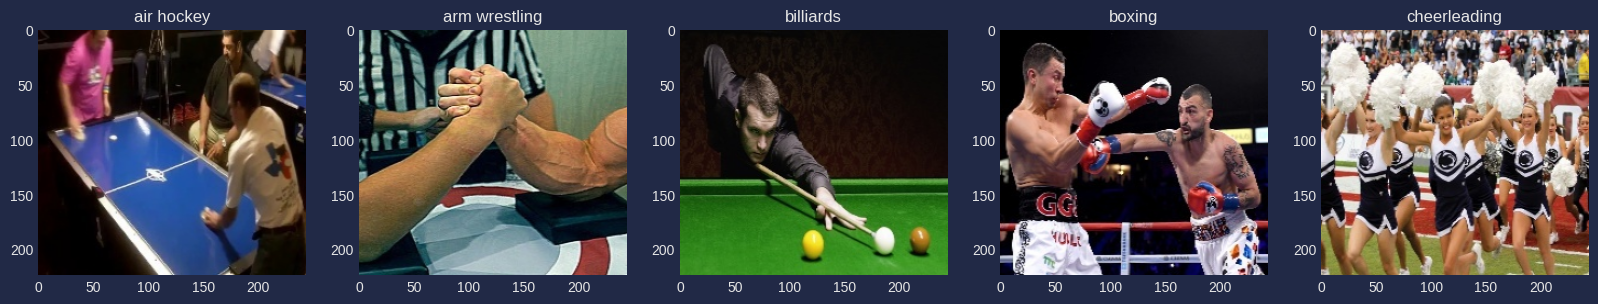

In [49]:
resize_img = T.Resize((224,244))
idx2cls = {j: i for i, j in train_dataset.class_to_idx.items()}
paths = ['/content/test/air hockey/4.jpg','/content/test/arm wrestling/4.jpg','/content/test/billiards/3.jpg','/content/valid/boxing/3.jpg','/content/test/cheerleading/4.jpg']
fig, ax = plt.subplots(1, 5, figsize=(20, 6))
for i in range(len(paths)):
  my_image = resize_img(io.read_image(paths[i])/255)
  ax[i].imshow(torch.permute(my_image, (1,2,0)))
  with torch.inference_mode():
    pred_label = model(my_image.unsqueeze(0).to(device)).argmax().item()
    ax[i].set_title(idx2cls[pred_label])
    ax[i].grid(False)

In [15]:
from sklearn.metrics import f1_score, confusion_matrix

In [17]:
torch.save(model.state_dict(), 'weights.pt')

In [51]:
model.state_dict()

OrderedDict([('model.conv1.weight',
              tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
                         -2.0325e-02,  8.8140e-03],
                        [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
                          2.9346e-02, -5.8331e-02],
                        [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
                          2.1868e-01, -7.2909e-02],
                        ...,
                        [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
                         -5.7855e-01,  2.2461e-01],
                        [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
                         -4.9317e-02, -6.8082e-02],
                        [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
                          1.8976e-01, -2.2302e-02]],
              
                       [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
                         -

In [47]:
model2 = MyResNet50()

In [42]:
model2.state_dict()

OrderedDict([('model.conv1.weight',
              tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
                         -2.0325e-02,  8.8140e-03],
                        [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
                          2.9346e-02, -5.8331e-02],
                        [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
                          2.1868e-01, -7.2909e-02],
                        ...,
                        [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
                         -5.7855e-01,  2.2461e-01],
                        [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
                         -4.9317e-02, -6.8082e-02],
                        [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
                          1.8976e-01, -2.2302e-02]],
              
                       [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
                         -

In [79]:
model2.load_state_dict(torch.load('/content/weights.pt'))

<All keys matched successfully>

In [45]:
model2.state_dict()

OrderedDict([('model.conv1.weight',
              tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
                         -2.0325e-02,  8.8140e-03],
                        [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
                          2.9346e-02, -5.8331e-02],
                        [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
                          2.1868e-01, -7.2909e-02],
                        ...,
                        [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
                         -5.7855e-01,  2.2461e-01],
                        [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
                         -4.9317e-02, -6.8082e-02],
                        [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
                          1.8976e-01, -2.2302e-02]],
              
                       [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
                         -

In [78]:
class MyResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(2048, 100)
        for i in self.model.parameters():
            i.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [82]:
model2.to('cuda')

MyResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [64]:
model2.eval()
model2(resize_img(io.read_image('/content/valid/air hockey/3.jpg')/255).unsqueeze(0).to('cuda')).argmax().item()

44

In [63]:
model(resize_img(io.read_image('/content/valid/air hockey/3.jpg')/255).unsqueeze(0).to(device)).argmax().item()

0

In [30]:
io.read_image('/content/valid/air hockey/3.jpg').unsqueeze(0).size()

torch.Size([1, 3, 224, 224])

In [83]:
model2.state_dict()

OrderedDict([('model.conv1.weight',
              tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
                         -2.0325e-02,  8.8140e-03],
                        [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
                          2.9346e-02, -5.8331e-02],
                        [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
                          2.1868e-01, -7.2909e-02],
                        ...,
                        [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
                         -5.7855e-01,  2.2461e-01],
                        [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
                         -4.9317e-02, -6.8082e-02],
                        [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
                          1.8976e-01, -2.2302e-02]],
              
                       [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
                         -

In [ ]:
resize_img(io.read_image(paths[i])/255)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

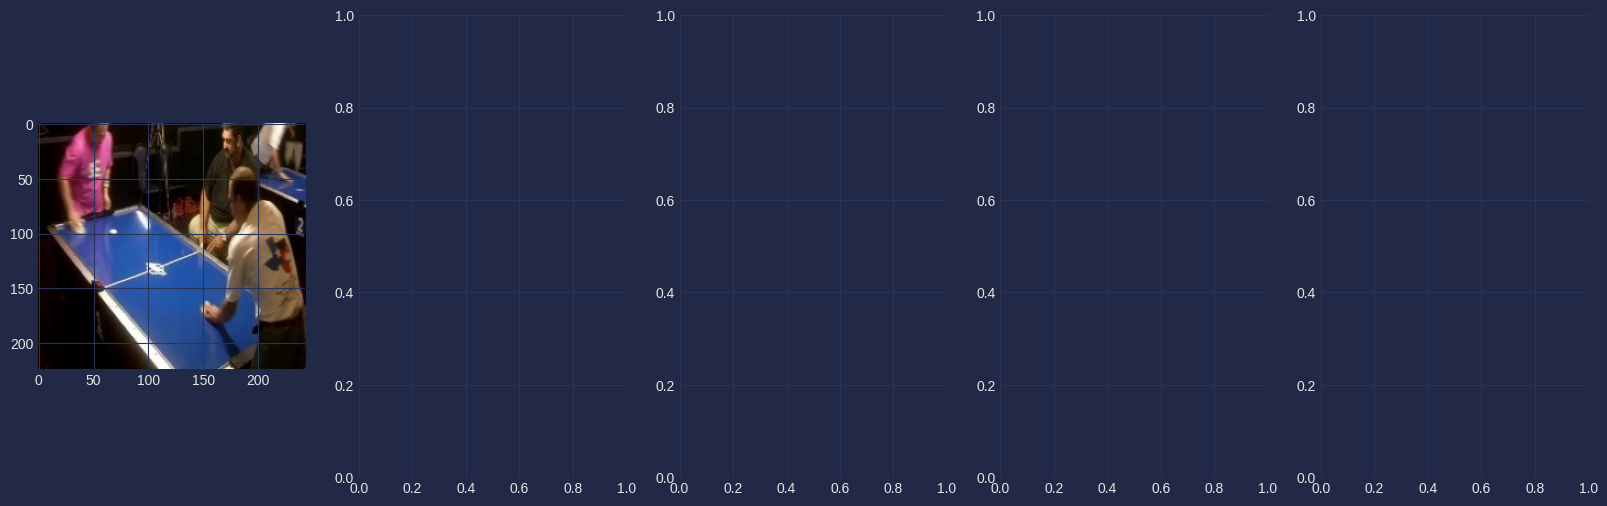

In [84]:
resize_img = T.Resize((224,244))
idx2cls = {j: i for i, j in train_dataset.class_to_idx.items()}
paths = ['/content/test/air hockey/4.jpg','/content/test/arm wrestling/4.jpg','/content/test/billiards/3.jpg','/content/valid/boxing/3.jpg','/content/test/cheerleading/4.jpg']
fig, ax = plt.subplots(1, 5, figsize=(20, 6))
for i in range(len(paths)):
  my_image = resize_img(io.read_image(paths[i])/255)
  ax[i].imshow(torch.permute(my_image, (1,2,0)))
  with torch.inference_mode():
    pred_label = model2(resize_img(io.read_image(paths[i]).unsqueeze(0)/255)).argmax().item()
    ax[i].set_title(idx2cls[pred_label])
    ax[i].grid(False)

In [65]:
testing_dataset = torchvision.datasets.ImageFolder('/content/valid',
                                                 transform=trnsfrms_valid)

torch.Size([1, 100]) tensor([[ -8.4794,  -4.5621,   2.6058, -16.0537,  -9.3240, -14.7560, -16.4113,
          -7.8378,  -8.2113,  -6.4173,  -8.5705,  -6.6644, -10.8759, -11.4060,
         -10.3751,  -9.8928, -11.9697, -10.1115,  -9.6045,  -9.5321, -19.1436,
          -8.7629,  -9.6565,  -5.8077, -12.5248,  -9.3669,  -8.3181, -12.2303,
         -13.0345, -14.0849, -13.3943, -13.2025, -15.1231, -13.2201, -10.3967,
          -7.1082,  -2.1269, -10.4171, -11.7539, -13.8024,  -3.9835,  -6.1974,
         -11.0388, -13.4053, -11.4726, -11.9652, -19.5451,  -8.2086, -13.8191,
         -10.7657,  -3.5863, -11.3612, -12.0616,  -8.9064, -17.6786, -12.9481,
         -14.3811, -12.9776, -17.3002, -14.0766,  -8.9769,  -9.8456,  -8.7567,
          -4.1881,  -8.4477, -12.7157,  -5.8299, -11.4486, -10.7385, -11.5240,
          -8.5234, -12.2037, -13.2384, -13.4970, -10.2361, -20.8940,  -8.8056,
         -13.0178, -16.1469, -12.0996, -16.6016, -11.9481, -14.2811, -14.3037,
         -16.1370, -14.4730,  -

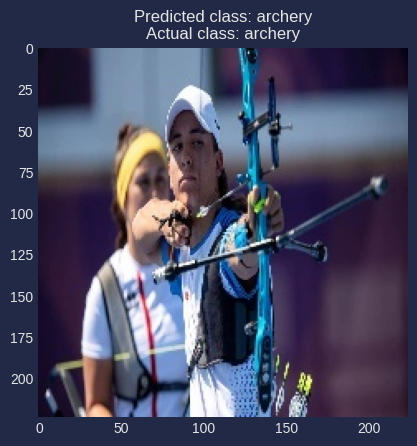

In [86]:
model2.eval()

image, label = testing_dataset[10]

plt.imshow(image.permute(1,2,0))
image = image.unsqueeze(0).to('cuda')
with torch.no_grad():
  pred=model2(image)
  print(pred.size(), pred)
  pred_class = idx2cls[pred.argmax(dim=1).item()]
plt.title(f'Predicted class: {pred_class}\nActual class: {idx2cls[label]}')
plt.grid(False)
plt.show()

torch.Size([1, 100]) tensor([[ -8.4794,  -4.5621,   2.6058, -16.0537,  -9.3240, -14.7560, -16.4113,
          -7.8378,  -8.2113,  -6.4173,  -8.5705,  -6.6644, -10.8759, -11.4060,
         -10.3751,  -9.8928, -11.9697, -10.1115,  -9.6045,  -9.5321, -19.1436,
          -8.7629,  -9.6565,  -5.8077, -12.5248,  -9.3669,  -8.3181, -12.2303,
         -13.0345, -14.0849, -13.3943, -13.2025, -15.1231, -13.2201, -10.3967,
          -7.1082,  -2.1269, -10.4171, -11.7539, -13.8024,  -3.9835,  -6.1974,
         -11.0388, -13.4053, -11.4726, -11.9652, -19.5451,  -8.2086, -13.8191,
         -10.7657,  -3.5863, -11.3612, -12.0616,  -8.9064, -17.6786, -12.9481,
         -14.3811, -12.9776, -17.3002, -14.0766,  -8.9769,  -9.8456,  -8.7567,
          -4.1881,  -8.4477, -12.7157,  -5.8299, -11.4486, -10.7385, -11.5240,
          -8.5234, -12.2037, -13.2384, -13.4970, -10.2361, -20.8940,  -8.8056,
         -13.0178, -16.1469, -12.0996, -16.6016, -11.9481, -14.2811, -14.3037,
         -16.1370, -14.4730,  -

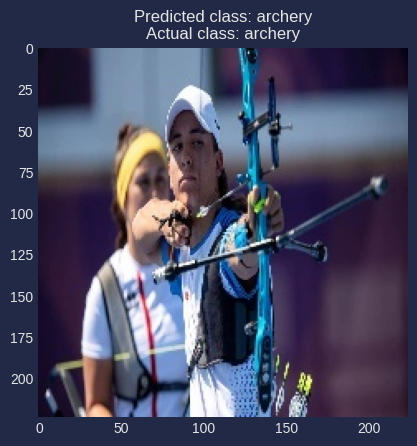

In [85]:
model.eval()
image, label = testing_dataset[10]

plt.imshow(image.permute(1,2,0))
image = image.unsqueeze(0).to('cuda')
with torch.no_grad():
  pred=model(image)
  print(pred.size(), pred)
  pred_class = idx2cls[pred.argmax(dim=1).item()]
plt.title(f'Predicted class: {pred_class}\nActual class: {idx2cls[label]}')
plt.grid(False)
plt.show()